# Overview: 

This notebook is created to do tasks given in this issue: [Visualization for misclassification](https://github.com/mozilla/PRESC/issues/7)

# Task:
- Develop a visualization that helps dig into misclassified datapoints in the test set.



I have used two classifiers to show misclassification. 
- Decision tree: for showing misclassification in confusion matrix.
- SVM: for showing misclassification at different datapoints in the test set by tuning the value of C - The Penalty Parameter.


In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Import packages to visualize the classifer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

# Import packages to do the classifying
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../../datasets/defaults.csv")

In [3]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})

In [4]:
target = df['def_pay'].copy()

In [5]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
#X = df[features].copy()
#features.columns
features = df[features].copy()
features.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

# Decision tree

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [7]:
#createing the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# doing predictions on the test
predictions = classifier.predict(X_test)


# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.812

This digits do not give the correct result. Thats why we need to see misclassification. Here I am adding misclassification to check the misclassified values.

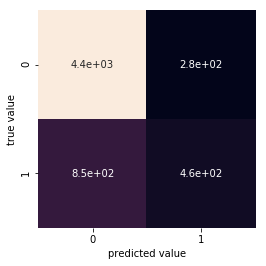

In [8]:
mat = confusion_matrix(y_test, predictions)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

A confusion matrix is showing the frequency of misclassification of our classifier.

# Support Vector Machine 

Support Vector Machine (SVM) is one of the most popular classification techniques which aims to minimize the number of misclassification errors directly. 

In [9]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = LinearSVC(C=1.0)

model = svc.fit(features_standardized, target)

c:\users\humayra\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Handling Linearly Inseparable Classes Using Kernels


In [10]:
np.random.seed(0)

features = np.random.randn(200, 2)

target_xor = np.logical_xor(features[:, 0] > 0, features[:, 1] > 0)
target = np.where(target_xor, 0, 1)

svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

model = svc.fit(features, target)

## Discussion 



For reasons best learned elsewhere, a support vector classifier can be represented as:

$$
f(x) = \beta_0 + \sum_{i\in s}^{p}{\alpha_i K(x_i, x_{i'})}
$$

where \beta is the bias, S is the set of all support vector observations, \alpha are the model parameters to be learned, and $(x_i, x_{i'})$ are pairs of two support vector observations, $x_i$ and $x_{i;}$. Don't worry if you don't understand kernel functions. For our purposed, just realized that K

1. Determines the type of hyperplane used to separate our classes and
2. we create different hyperplanes by using different kernels.

For example if we wanted the basic linear hyperplane used to separate our classes, we can use the linear kernel:

$$
K(x_i, x_{i'}) = \sum_{j=1}^{p}{x_{ij}x_{i'j}}
$$

where p is the number of features. However, if we wanted a nonlinear decision boundary, we swap the linear kernel with a polynomial kernel:

$$
K(x_i, x_{i'}) = (1 + \sum_{j=1}^{p}{x_{ij}x_{i'j}})^2
$$

where d is the degree of the polynomial kernel function. Alternatively, we can use one of the most common kernels in support vector machines, the radial basis function kernel:

$$
K(x_i, x_{i'}) = e^{(-\gamma \sum_{j=1}^{p}{(x_{ij}x_{i'j})^2})}
$$

where \gamma is a hyperparameter and must be greater than zero. The main point of the preceding explanation is that if we have linearly inseparable data we can swap out a linear kernel with an alternative kernel to create a nonlinear hyperplane decision boundary.




Radial Basis Function is a commonly used kernel in SVC. an SVC classifier using an RBF kernel has two parameters: `gamma` and `C`.

### Gamma
gamma is a parameter of the RBF kernel and can be thought of as the ‘spread’ of the kernel and therefore the decision region. When gamma is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad. When gamma is high, the ‘curve’ of the decision boundary is high, which creates islands of decision-boundaries around data points. We will see this very clearly below.

### C
C is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is small, the classifier is okay with misclassified data points (high bias, low variance). When C is large, the classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance).




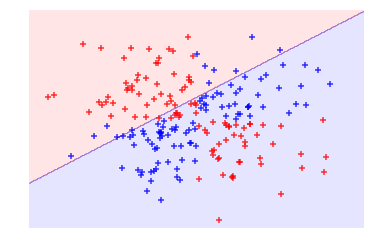

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [11]:
def plot_decision_regions(X, y, classifier):
    cmap = ListedColormap(("red", "blue"))
    xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker="+", label=cl)
        
svc_linear = SVC(kernel="linear", random_state=0, C=1)

svc_linear.fit(features, target)
plot_decision_regions(features, target, classifier=svc_linear)
plt.axis("off"), plt.show()

## Gamma
In the four charts below, we apply the same SVC-RBF classifier to the same data while holding C constant. The only difference between each chart is that each time we will increase the value of gamma. By doing so, we can visually see the effect of gamma on the decision boundary.


### Gamma = 0.01


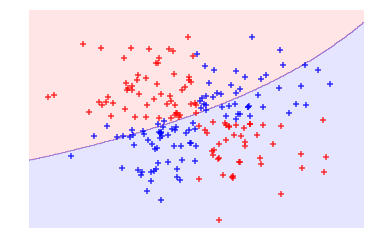

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [12]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

In the case of our SVC classifier and data, when using a low gamma like 0.01, the decision boundary is not very curvy, rather it is just one big sweeping arch.


### Gamma = 1


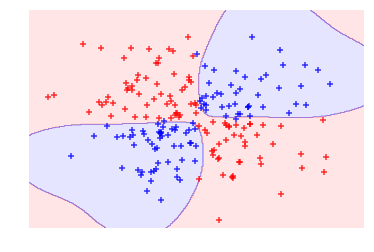

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [13]:
svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

We can see a big difference when we increase the gamma to 1. Now the decision boundary is starting to better cover the spread of the data.


### Gamma = 10


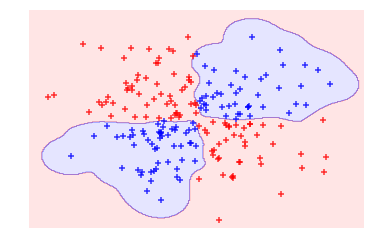

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [14]:
svc = SVC(kernel="rbf", random_state=0, gamma=10, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At `gamma = 10` the spread of the kernel is less pronounced. The decision boundary starts to be highly effected by individual data points (i.e. variance).


### Gamma = 100


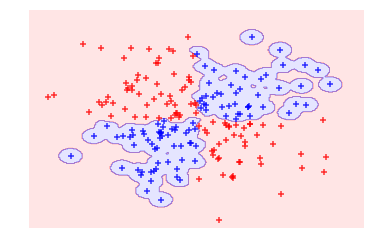

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [15]:
svc = SVC(kernel="rbf", random_state=0, gamma=100, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

With high gamma, the decision boundary is almost entirely dependent on individual data points, creating islands. This data is clearly overfitted.

## C - The Penalty Parameter
Now we will repeat the process for C: we will use the same classifier, same data, and hold gamma constant. The only thing we will change is the C, the penalty for misclassification.


### C = 1


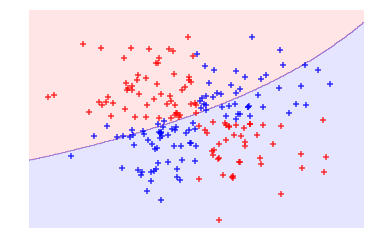

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [16]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

With C = 1, the classifier is clearly tolerant of misclassified data point. There are many red points in the blue region and blue points in the red region.



### C = 10


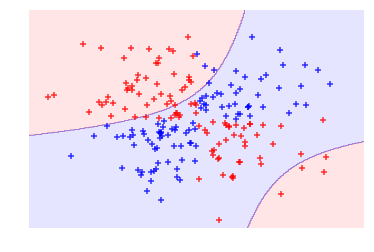

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [17]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=10)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 10, the classifier is less tolerant to misclassified data points and therefore the decision boundary is more severe.


### C = 100

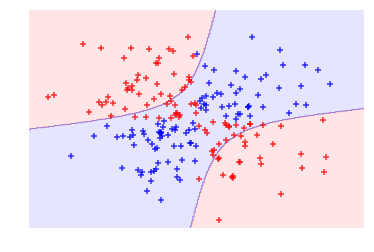

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [18]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=100)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

### C = 1000

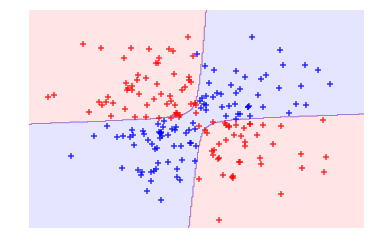

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [19]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

When C = 1000, the classifier starts to become very intolerant to misclassified data points and thus the decision boundary becomes less biased and has more variance (i.e. more dependent on the individual data points).

### C = 10000

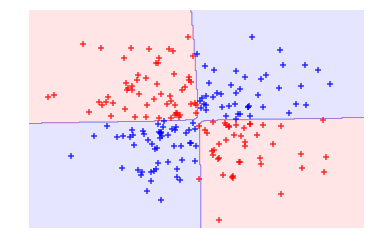

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [20]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=10000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 10000, the classifier “works really hard” to not misclassify data points and we see signs of overfitting.

### C = 100000

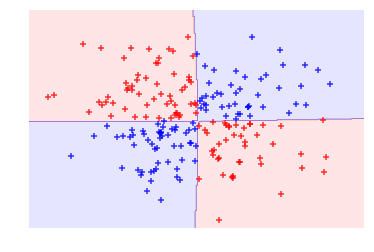

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [21]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=100000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 100000, the classifier is heavily penalized for any misclassified data points and therefore the margins are small.

So from above plots, we can come to conclusion that if your data has some amount of overlap or the classifier can be misclassified. 

We can see, very large $C$, the margin is hard, and points cannot lie in it.
And for smaller $C$, the margin is softer, and can grow to encompass some points.

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure

In [22]:
features = np.random.randn(200, 2)

target_xor = np.logical_xor(features[:, 0] > 0, features[:, 1] > 0)
target = np.where(target_xor, 0, 1)

svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

model = svc.fit(features, target)

## Overview of Support Vector Machine Summary

Support vector machine is a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.